# RQ1 Phase 2a Analysis: Qwen3-30B-A3B Models for Vulnerability Detection

This notebook analyzes the results of RQ1 Phase 2a experiments comparing:
- **Thinking model** (Qwen3-30B-A3B-Thinking-2507) vs **Baseline model** (Qwen3-30B-A3B-Instruct-2507)
- **Zero-shot** vs **Few-shot** prompting strategies
- **MoE Architecture**: 30B total parameters, 3B active per token

## Experiments Overview

| Experiment | Model | Prompting | Samples | Status |
|------------|-------|-----------|---------|--------|
| Instruct SA-zero | Instruct | Zero-shot | 386 | ✅ Complete |
| Instruct SA-few | Instruct | Few-shot | 386 | ✅ Complete |
| Thinking SA-zero | Thinking | Zero-shot | 386 | ✅ Complete |
| Thinking SA-few | Thinking | Few-shot | 386 | ✅ Complete |

## Infrastructure

- **Platform**: RunPod H100 SXM 80GB (4 pods in parallel)
- **vLLM Config**: max-model-len 65536, dtype auto, gpu-memory-utilization 0.90
- **Dataset**: VulTrial 386 samples
- **Cost**: $9.96 total (~1 hr × 4 pods @ $2.49/hr)

## 1. Setup and Data Loading

In [13]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Paths - Phase 2a results from RunPod
RESULTS_DIR = Path('../results/runpod')
OUTPUT_DIR = Path('../results/analysis_phase2a')
OUTPUT_DIR.mkdir(exist_ok=True, parents=True)

print(f"Results directory: {RESULTS_DIR}")
print(f"Output directory: {OUTPUT_DIR}")

Results directory: ../results/runpod
Output directory: ../results/analysis_phase2a


In [14]:
# Result directories for Phase 2a (from RunPod H100)
RESULT_DIRS = {
    'instruct_zero': 'instruct_zero_20251020_194844',
    'instruct_few': 'instruct_few_20251020_200040',
    'thinking_zero': 'thinking_zero_20251020_215332',
    'thinking_few': 'thinking_few_20251020_214835',
}

# File base names (extracted from directory listing)
FILE_BASES = {
    'instruct_zero': 'Sa-zero_Qwen-Qwen3-30B-A3B-Instruct-2507_20251020-104948',
    'instruct_few': 'Sa-few_Qwen-Qwen3-30B-A3B-Instruct-2507_20251020-111953',
    'thinking_zero': 'Sa-zero_Qwen-Qwen3-30B-A3B-Thinking-2507_20251020-104530',
    'thinking_few': 'Sa-few_Qwen-Qwen3-30B-A3B-Thinking-2507_20251020-111009',
}

# CodeCarbon directory mapping
CODECARBON_DIRS = {
    'instruct_zero': 'codecarbon_baseline_sa-zero',
    'instruct_few': 'codecarbon_baseline_sa-few',
    'thinking_zero': 'codecarbon_thinking_sa-zero',
    'thinking_few': 'codecarbon_thinking_sa-few',
}

def load_detailed_results(exp_name):
    """Load detailed results from JSONL file"""
    result_dir = RESULTS_DIR / RESULT_DIRS[exp_name]
    file_base = FILE_BASES[exp_name]
    jsonl_file = result_dir / f"{file_base}_detailed_results.jsonl"
    
    results = []
    with open(jsonl_file, 'r') as f:
        for line in f:
            if line.strip():
                results.append(json.loads(line))
    
    return pd.DataFrame(results)

def load_energy_data(exp_name):
    """Load energy tracking JSON"""
    result_dir = RESULTS_DIR / RESULT_DIRS[exp_name]
    file_base = FILE_BASES[exp_name]
    energy_file = result_dir / f"{file_base}_energy_tracking.json"
    
    if energy_file.exists():
        with open(energy_file, 'r') as f:
            return json.load(f)
    return None

def load_codecarbon_emissions(exp_name):
    """Load CodeCarbon emissions CSV"""
    result_dir = RESULTS_DIR / RESULT_DIRS[exp_name]
    codecarbon_dir = result_dir / CODECARBON_DIRS[exp_name]
    emissions_file = codecarbon_dir / 'emissions.csv'
    
    if emissions_file.exists():
        return pd.read_csv(emissions_file)
    return None

# Load all experiments
experiments = {}

for exp_name in RESULT_DIRS.keys():
    print(f"Loading {exp_name}...")
    experiments[exp_name] = {
        'df': load_detailed_results(exp_name),
        'energy': load_energy_data(exp_name),
        'codecarbon': load_codecarbon_emissions(exp_name)
    }
    print(f"  Loaded {len(experiments[exp_name]['df'])} samples")
    
    # Show CodeCarbon status
    if experiments[exp_name]['codecarbon'] is not None:
        cc_sessions = len(experiments[exp_name]['codecarbon'])
        cc_total = experiments[exp_name]['codecarbon']['emissions'].sum()
        print(f"  CodeCarbon: {cc_sessions} sessions, {cc_total:.6f} kg CO2")
    else:
        print(f"  CodeCarbon: No data")

print("\n✓ All data loaded successfully")

Loading instruct_zero...
  Loaded 386 samples
  CodeCarbon: 1 sessions, 0.059305 kg CO2
Loading instruct_few...
  Loaded 386 samples
  CodeCarbon: 1 sessions, 0.047297 kg CO2
Loading thinking_zero...
  Loaded 386 samples
  CodeCarbon: 1 sessions, 0.223806 kg CO2
Loading thinking_few...
  Loaded 385 samples
  CodeCarbon: 2 sessions, 0.193529 kg CO2

✓ All data loaded successfully


## 2. Performance Metrics Calculation

In [15]:
def calculate_metrics(df):
    """Calculate performance metrics from detailed results"""
    # Add error column if it doesn't exist, fill with empty string
    if 'error' not in df.columns:
        df['error'] = ''
    
    # Fill NaN values in error column with empty string
    df['error'] = df['error'].fillna('')
    
    # Filter out skipped/error samples (keep only samples with no error or empty error)
    valid_df = df[df['error'] == ''].copy()
    
    if len(valid_df) == 0:
        return None
    
    y_true = valid_df['ground_truth'].values
    y_pred = valid_df['vuln'].values
    
    # Calculate metrics
    tp = np.sum((y_pred == 1) & (y_true == 1))
    tn = np.sum((y_pred == 0) & (y_true == 0))
    fp = np.sum((y_pred == 1) & (y_true == 0))
    fn = np.sum((y_pred == 0) & (y_true == 1))
    
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return {
        'samples': len(valid_df),
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'tp': int(tp),
        'tn': int(tn),
        'fp': int(fp),
        'fn': int(fn),
        'errors': len(df) - len(valid_df)
    }

# Calculate metrics for all experiments
for exp_name, data in experiments.items():
    data['metrics'] = calculate_metrics(data['df'])

print("✓ Metrics calculated for all experiments")

✓ Metrics calculated for all experiments


## 3. Results Summary Table

In [16]:
# Create summary table
summary_rows = []

for exp_name, data in experiments.items():
    m = data['metrics']
    e = data['energy'] or {}
    
    # Calculate average CO2 per sample
    total_co2 = e.get('total_emissions', 0)
    samples = m['samples']
    avg_co2 = total_co2 / samples if samples > 0 else 0
    
    row = {
        'Experiment': exp_name.replace('_', ' ').title(),
        'Model': 'Thinking' if 'thinking' in exp_name else 'Instruct',
        'Prompting': 'Few-shot' if 'few' in exp_name else 'Zero-shot',
        'Samples': m['samples'],
        'Accuracy': f"{m['accuracy']:.4f}",
        'Precision': f"{m['precision']:.4f}",
        'Recall': f"{m['recall']:.4f}",
        'F1-Score': f"{m['f1_score']:.4f}",
        'CO2 (kg)': f"{total_co2:.6f}",
        'CO2/sample (g)': f"{avg_co2*1000:.4f}",  # Convert to grams
    }
    summary_rows.append(row)

summary_df = pd.DataFrame(summary_rows)
summary_df

,Experiment,Model,Prompting,Samples,Accuracy,Precision,Recall,F1-Score,CO2 (kg),CO2/sample (g)
0,Instruct Zero,Instruct,Zero-shot,386,0.5415,0.5471,0.4819,0.5124,0.059305,0.1536
1,Instruct Few,Instruct,Few-shot,386,0.5518,0.6163,0.2746,0.3799,0.047297,0.1225
2,Thinking Zero,Thinking,Zero-shot,386,0.5259,0.5236,0.5751,0.5481,0.223806,0.5798
3,Thinking Few,Thinking,Few-shot,384,0.5182,0.5235,0.4611,0.4904,0.193529,0.5040


In [17]:
# Save summary table
summary_df.to_csv(OUTPUT_DIR / 'rq1_phase2a_summary_table.csv', index=False)
print(f"✓ Summary table saved to {OUTPUT_DIR / 'rq1_phase2a_summary_table.csv'}")

✓ Summary table saved to ../results/analysis_phase2a/rq1_phase2a_summary_table.csv


## 4. Performance Comparison Visualizations

In [18]:
# Prepare data for visualization
metrics_data = []

for exp_name, data in experiments.items():
    m = data['metrics']
    model_type = 'Thinking' if 'thinking' in exp_name else 'Instruct'
    prompting = 'Few-shot' if 'few' in exp_name else 'Zero-shot'
    
    metrics_data.append({
        'Experiment': f"{model_type}\n{prompting}",
        'Model': model_type,
        'Prompting': prompting,
        'Accuracy': m['accuracy'],
        'Precision': m['precision'],
        'Recall': m['recall'],
        'F1-Score': m['f1_score']
    })

metrics_df = pd.DataFrame(metrics_data)

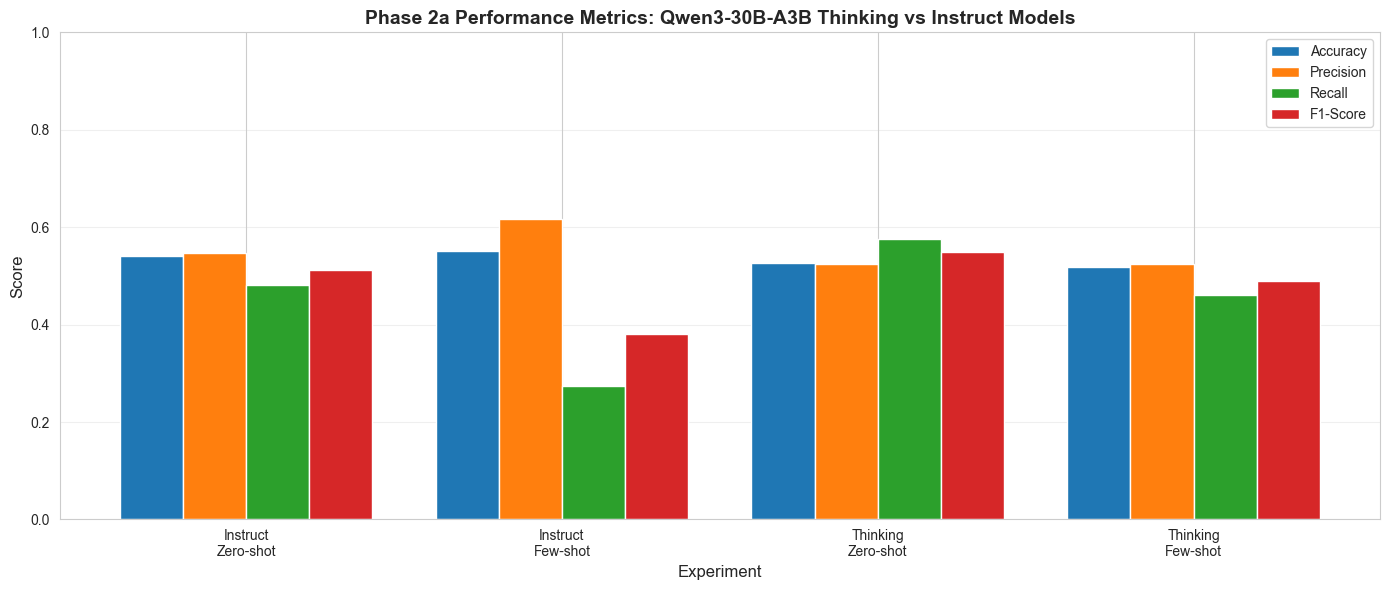

✓ Saved to ../results/analysis_phase2a/phase2a_metrics_comparison.png


In [19]:
# Plot 1: Grouped bar chart for all metrics
fig, ax = plt.subplots(figsize=(14, 6))

metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x = np.arange(len(metrics_df))
width = 0.2

for i, metric in enumerate(metrics_to_plot):
    ax.bar(x + i*width, metrics_df[metric], width, label=metric)

ax.set_xlabel('Experiment', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Phase 2a Performance Metrics: Qwen3-30B-A3B Thinking vs Instruct Models', fontsize=14, fontweight='bold')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(metrics_df['Experiment'])
ax.legend()
ax.set_ylim([0, 1.0])
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'phase2a_metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved to {OUTPUT_DIR / 'phase2a_metrics_comparison.png'}")

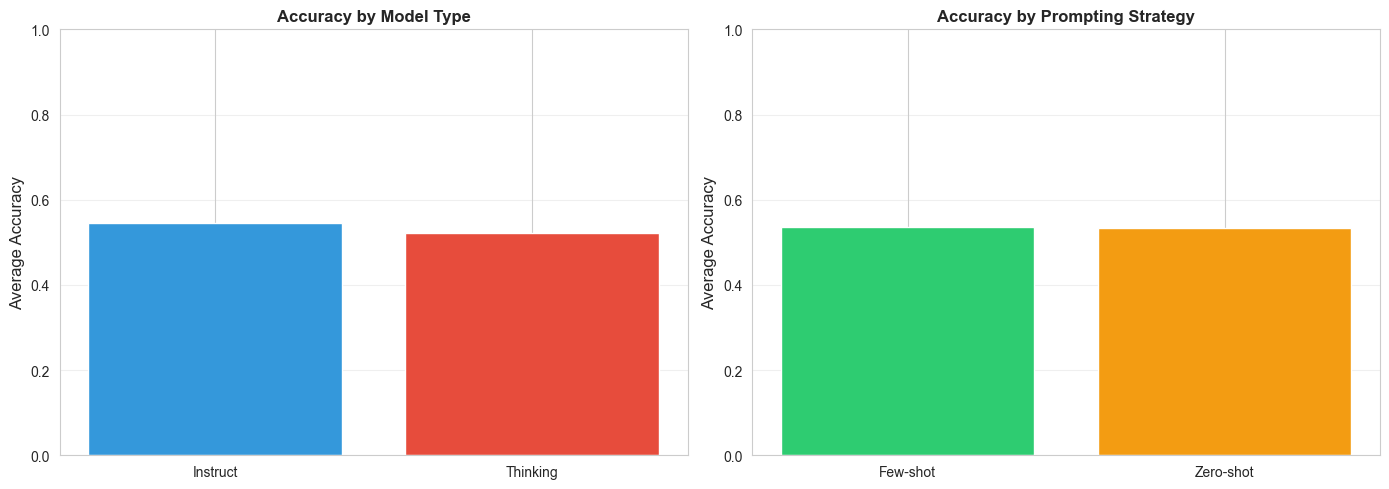

✓ Saved to ../results/analysis_phase2a/accuracy_comparison.png


In [20]:
# Plot 2: Accuracy comparison by model and prompting strategy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# By Model Type
model_comparison = metrics_df.groupby('Model')['Accuracy'].mean()
ax1.bar(model_comparison.index, model_comparison.values, color=['#3498db', '#e74c3c'])
ax1.set_ylabel('Average Accuracy', fontsize=12)
ax1.set_title('Accuracy by Model Type', fontsize=12, fontweight='bold')
ax1.set_ylim([0, 1.0])
ax1.grid(axis='y', alpha=0.3)

# By Prompting Strategy
prompting_comparison = metrics_df.groupby('Prompting')['Accuracy'].mean()
ax2.bar(prompting_comparison.index, prompting_comparison.values, color=['#2ecc71', '#f39c12'])
ax2.set_ylabel('Average Accuracy', fontsize=12)
ax2.set_title('Accuracy by Prompting Strategy', fontsize=12, fontweight='bold')
ax2.set_ylim([0, 1.0])
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'accuracy_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved to {OUTPUT_DIR / 'accuracy_comparison.png'}")

## 5. Confusion Matrices

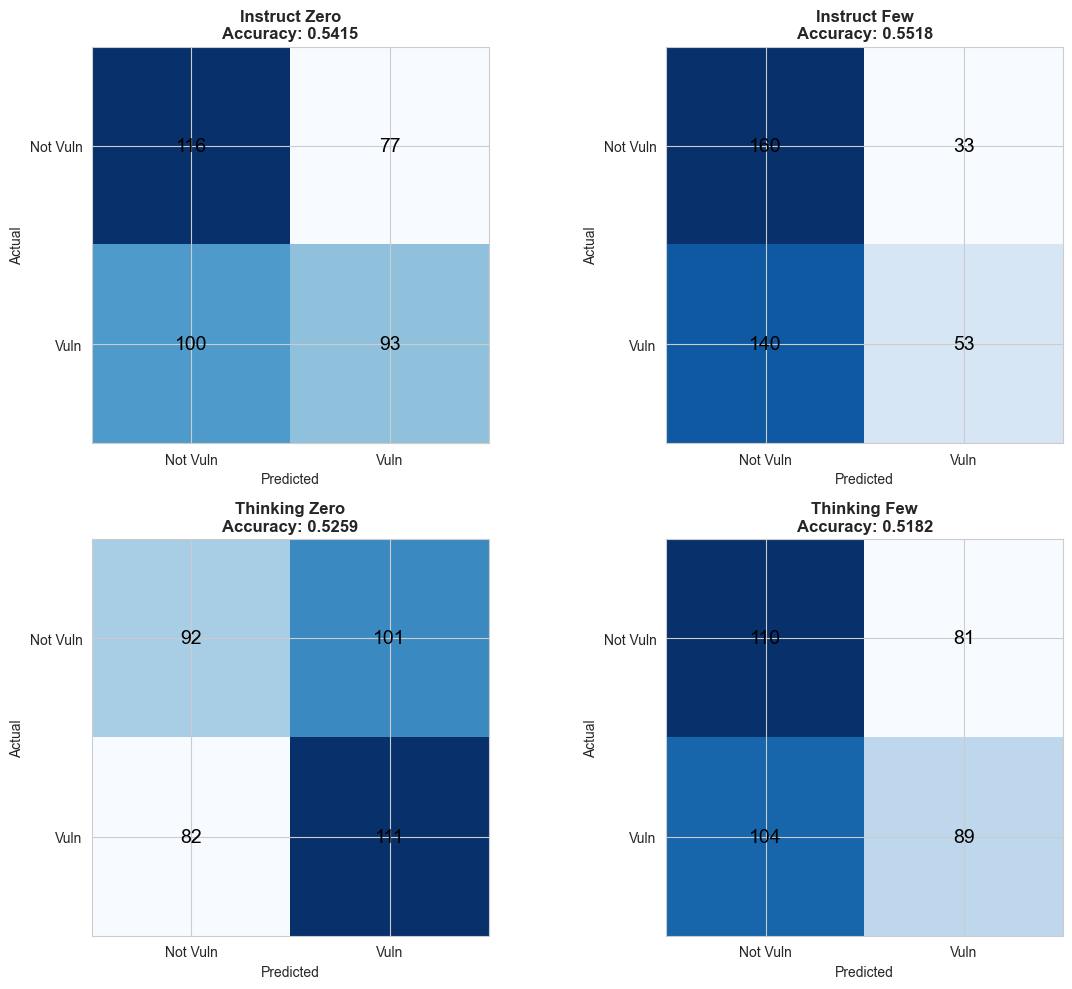

✓ Saved to ../results/analysis_phase2a/confusion_matrices.png


In [21]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for idx, (exp_name, data) in enumerate(experiments.items()):
    m = data['metrics']
    
    # Create confusion matrix
    cm = np.array([[m['tn'], m['fp']], 
                   [m['fn'], m['tp']]])
    
    # Plot
    im = axes[idx].imshow(cm, cmap='Blues')
    axes[idx].set_xticks([0, 1])
    axes[idx].set_yticks([0, 1])
    axes[idx].set_xticklabels(['Not Vuln', 'Vuln'])
    axes[idx].set_yticklabels(['Not Vuln', 'Vuln'])
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')
    
    title = exp_name.replace('_', ' ').title()
    axes[idx].set_title(f'{title}\nAccuracy: {m["accuracy"]:.4f}', fontweight='bold')
    
    # Annotate cells
    for i in range(2):
        for j in range(2):
            text = axes[idx].text(j, i, cm[i, j],
                                ha="center", va="center", color="black", fontsize=14)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved to {OUTPUT_DIR / 'confusion_matrices.png'}")

## 6. Energy Consumption Analysis

In [22]:
# Extract energy data
energy_data = []

for exp_name, data in experiments.items():
    e = data['energy'] or {}
    m = data['metrics']
    model_type = 'Thinking' if 'thinking' in exp_name else 'Instruct'
    prompting = 'Few-shot' if 'few' in exp_name else 'Zero-shot'
    
    total_co2 = e.get('total_emissions', 0)
    samples = m['samples']
    avg_co2 = total_co2 / samples if samples > 0 else 0
    
    energy_data.append({
        'Experiment': f"{model_type}\n{prompting}",
        'Model': model_type,
        'Prompting': prompting,
        'Total CO2 (kg)': total_co2,
        'Avg CO2/sample (kg)': avg_co2,
        'Avg CO2/sample (g)': avg_co2 * 1000  # Convert to grams for display
    })

energy_df = pd.DataFrame(energy_data)
energy_df

,Experiment,Model,Prompting,Total CO2 (kg),Avg CO2/sample (kg),Avg CO2/sample (g)
0,Instruct\nZero-shot,Instruct,Zero-shot,0.059305,0.000154,0.153639
1,Instruct\nFew-shot,Instruct,Few-shot,0.047297,0.000123,0.122531
2,Thinking\nZero-shot,Thinking,Zero-shot,0.223806,0.000580,0.579808
3,Thinking\nFew-shot,Thinking,Few-shot,0.193529,0.000504,0.503981


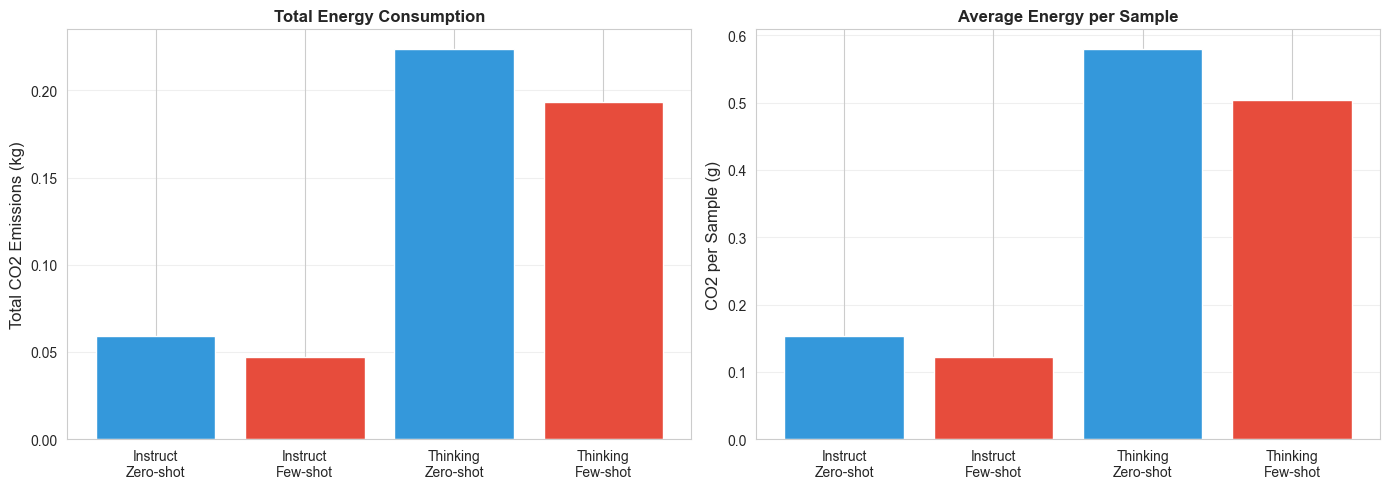

✓ Saved to ../results/analysis_phase2a/energy_consumption.png


In [23]:
# Plot energy consumption
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Total CO2
ax1.bar(energy_df['Experiment'], energy_df['Total CO2 (kg)'], 
        color=['#3498db', '#e74c3c', '#3498db', '#e74c3c'])
ax1.set_ylabel('Total CO2 Emissions (kg)', fontsize=12)
ax1.set_title('Total Energy Consumption', fontsize=12, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
ax1.tick_params(axis='x', rotation=0)

# Average per sample
ax2.bar(energy_df['Experiment'], energy_df['Avg CO2/sample (g)'],
        color=['#3498db', '#e74c3c', '#3498db', '#e74c3c'])
ax2.set_ylabel('CO2 per Sample (g)', fontsize=12)
ax2.set_title('Average Energy per Sample', fontsize=12, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)
ax2.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'energy_consumption.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved to {OUTPUT_DIR / 'energy_consumption.png'}")

## 8. Export Results for Report

In [24]:
# Save all results to Excel for easy reporting
with pd.ExcelWriter(OUTPUT_DIR / 'rq1_phase2a_complete_results.xlsx') as writer:
    summary_df.to_excel(writer, sheet_name='Summary', index=False)
    energy_df.to_excel(writer, sheet_name='Energy', index=False)
    
    # Detailed metrics
    detailed_metrics = []
    for exp_name, data in experiments.items():
        m = data['metrics']
        detailed_metrics.append({
            'Experiment': exp_name,
            **m
        })
    pd.DataFrame(detailed_metrics).to_excel(writer, sheet_name='Detailed Metrics', index=False)

print(f"✓ Complete results exported to {OUTPUT_DIR / 'rq1_phase2a_complete_results.xlsx'}")

✓ Complete results exported to ../results/analysis_phase2a/rq1_phase2a_complete_results.xlsx
